In [1]:
%env GDAL_DATA = /usr/share/gdal/2.2/

env: GDAL_DATA=/usr/share/gdal/2.2/


# Water Across Synthetic Aperature Radar (WASARD)
WASARD is a general purpose transfer model between optical and SAR imagery for water classification.   
A trained WASARD model can be executed on SAR imagery to create water classification maps over a region.  

This notebook is inspired by an IGARSS publication titled [Water Across Synthetic Aperture Radar Data (WASARD): SAR Water Body Classification for the Open Data Cube](https://www.igarss2018.org/Papers/viewpapers.asp?papernum=3380) authored by Zachary Kreiser, Brian Killough, Syed R Rizvi.  


WASARD is trained using water classifications on optical imagery as a point of reference.  A machine learning model is used to approximate a transfer function between SAR data and Optical Classifications.  


>### Details regarding WASARD in this notebook  
> `Transfer Model:` Linear SVM  
> `Optical water classifier:` WOFS  
> `Optical Source:` Landsat 8  
> `SAR Target`: Sentinel 1a  


# Training process  
![](./diagrams/WASARD/flow_chart.png)




# In this notebook
* Existing coordinates are loaded for `Sentinel1` and `Landsat8` Imagery
* Upon comparison,coordinates are used to inform how data should be loaded.  
* `Sentinel1` imagery is loaded.
* `Landsat8`  imagery is loaded, reprojected, and upsampled to match the resolution of `Sentine1` 
* an existing water classifier is run on optical data.  
* optical water classifications are averaged across time and visualized
* a wasard model is created and trained  
* a wasard model is run on sentinel data
* the output of wasard is averaged across time and visualized 

<br>

# Retreiving/Cleaning Data

### Connect to the data cube

In [2]:
import datacube
dc = datacube.Datacube(app = "[notebook][wasard][samoa]")

/home/localuser/Datacube/datacube_env/lib/python3.6/site-packages/psycopg2-2.7.5-py3.6-linux-x86_64.egg/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


### Define Extents of Analysis  

In [3]:
sar_product_name = "s1g_gamma0_samoa"
optical_product_name = "ls8_lasrc_samoa"

# #Sa'anapu
# longitude_extent = (-171.904492, -171.790327)
# latitude_extent = (-14.0  , -13.962341)

#Apia
latitude_extent = -13.853425,-13.815715
longitude_extent =-171.787842, -171.681356

date_range = ('2016-8-1','2018-3-1')

In [4]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = latitude_extent, longitude = longitude_extent)

### Examine Coordinate Extents 

In [5]:
sentinel_coordinates =  dc.load(product = sar_product_name,
                                latitude = latitude_extent,
                                longitude = longitude_extent,
                                time = date_range,
                                measurements = [])
landsat_coordinates  =  dc.load(product = optical_product_name,
                                latitude = latitude_extent,
                                longitude = longitude_extent,
                                time = date_range,
                                measurements = [])

In [6]:
import utils.data_cube_utilities.xarray_bokeh_plotting as xr_bokeh
xr_bokeh.init_notebook() 

Loading BokehJS ...

In [7]:
xr_bokeh.dim_alignement( sentinel_coordinates.isel(latitude = slice(0,100), longitude = slice(0,100)), " Sentinel 1",
                          landsat_coordinates.isel(latitude = slice(0,100), longitude = slice(0,100)),  "Landsat 8")

### Load and reproject  

Add bit about reprojecting landsat the way I do with sentinel.   

** Sentinel CRS**

In [8]:
sentinel_details = dc.list_products()[dc.list_products()["name"].str.contains(sar_product_name)]
sentinel_details

,name,description,time,lat,instrument,product_type,platform,label,creation_time,lon,format,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
99,s1g_gamma0_samoa,"Sentinel-1A/B SAR Gamma0, processed to the GEE...",None,None,SAR,gamma0,SENTINEL_1,None,None,None,NetCDF,EPSG:4326,"[-0.000180831826401447, 0.000184842883548983]","[1, 1]","(latitude, longitude)"


In [9]:
sentinel_crs        = str(sentinel_details['crs'].values[0])
sentinel_resolution = tuple(sentinel_details['resolution'].values[0])

In [10]:
print (sentinel_crs)

EPSG:4326


### Load both SAR and Optical imagery 

In [11]:
sentinel_dataset     =  dc.load(product = sar_product_name,
                                latitude = latitude_extent,
                                longitude = longitude_extent,
                                time = date_range,
                                )

In [12]:
landsat_dataset     =    dc.load(product = optical_product_name,
                                latitude = latitude_extent,
                                longitude = longitude_extent,
                                time = date_range,
                                output_crs = sentinel_crs,
                                resolution = sentinel_resolution
                                )

### compare reprojected coordinates for alignment. 

In [13]:
subset_of_landsat_coords = landsat_dataset.isel(latitude = slice(0,100),
                                        longitude = slice(0,100),
                                        time = 0).coords

In [14]:
subset_of_sentinel_coords = sentinel_dataset.isel(latitude = slice(0,100),
                                        longitude = slice(0,100),
                                        time = 0).coords

In [15]:
xr_bokeh.dim_alignement(subset_of_sentinel_coords, "S1",
                        subset_of_landsat_coords, "LS")

### Clean SAR Data  

In [16]:
import xarray as xr  
import numpy as np
import matplotlib.pyplot as plt

def remove_all_zero(dataset):
    return dataset.drop([c[0].values 
        for c in [(t,np.count_nonzero(dataset.sel(time=t).vv)) 
                  for t in dataset.time] if c[1]==0],dim='time')

In [17]:
from typing import List  
import itertools

has_time_dimension = lambda x: "time" in dict(x.dims).keys()
get_first = lambda x: x[0]
get_last =  lambda x: x[-1]


def group_dates_by_day( dates: List[np.datetime64]) -> List[List[np.datetime64]]:
    generate_key = lambda b: ((b - np.datetime64('1970-01-01T00:00:00Z')) / (np.timedelta64(1, 'h')*24)).astype(int)
    return [list(group) for key, group in itertools.groupby(dates, key=generate_key)]

def reduce_on_day(ds: xr.Dataset,
                  reduction_func: np.ufunc = np.nanmean) -> xr.Dataset:
    #Group dates by day into date_groups
    day_groups = group_dates_by_day(ds.time.values)
    
    #slice large dataset into many smaller datasets by date_group
    group_chunks = (ds.sel(time = t) for t in day_groups)
    
    #reduce each dataset using something like "average" or "median" such that many values for a day become one value   
    group_slices = (_ds.reduce(reduction_func, dim = "time") for _ds in group_chunks if has_time_dimension(_ds))

    #recombine slices into larger dataset
    new_dataset  = xr.concat(group_slices, dim = "time") 
    
    #rename times values using the first time in each date_group  
    new_times = list(map(get_first, day_groups))    
    new_dataset = new_dataset.reindex(dict(time = np.array(new_times)))
    
    return new_dataset
    

In [18]:
sentinel_dataset = remove_all_zero(sentinel_dataset)
sentinel_dataset = reduce_on_day(sentinel_dataset)

/home/localuser/Datacube/datacube_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  # Remove the CWD from sys.path while we load stuff.


In [19]:
subset_of_landsat_coords = landsat_dataset.isel(latitude = 0, longitude = 0).coords
subset_of_sentinel_coords = sentinel_dataset.isel(latitude = 0, longitude = 0).coords
xr_bokeh.dim_alignement(subset_of_sentinel_coords, "S1",
                        subset_of_landsat_coords, "LS")

# Examine Optical Data

In [20]:
from utils.data_cube_utilities.dc_mosaic import ls8_unpack_qa

In [21]:
from utils.data_cube_utilities.dc_mosaic import ls8_unpack_qa
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic
import xarray as xr  
import numpy as np

def clean_mask_ls8(ds:xr.Dataset) -> np.array:
    clear_xarray  = ls8_unpack_qa(ds.pixel_qa, "clear")  
    water_xarray  = ls8_unpack_qa(ds.pixel_qa, "water")

    cloud_free_boolean_mask = np.logical_or(clear_xarray, water_xarray)
    return cloud_free_boolean_mask

def median_mosaic_ls8(dataset):
    # The mask here is based on pixel_qa products. It comes bundled in with most Landsat Products.
        return create_median_mosaic(dataset, clean_mask = clean_mask_ls8(dataset))

In [22]:
mosaic = median_mosaic_ls8(landsat_dataset.isel(time = slice(0,20)))

(<Figure size 1080x2967.43 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f06151256a0>)

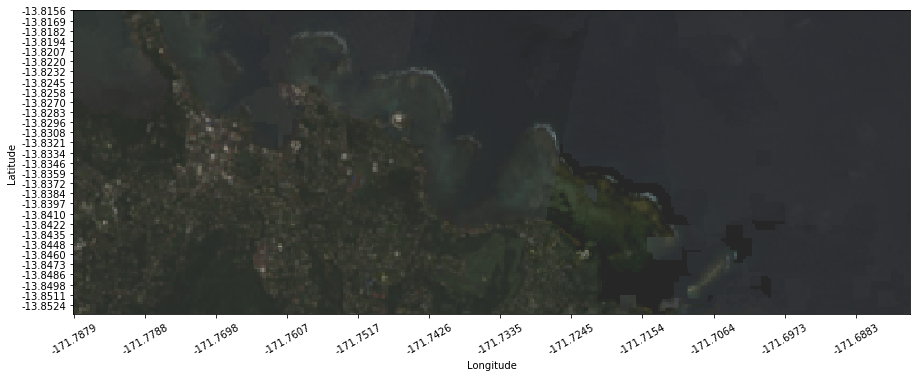

In [23]:
from utils.data_cube_utilities.dc_rgb import rgb
rgb(mosaic, bands=['red', 'green', 'blue'], width= 15)

# Water Classification: Optical Imagery

>### Import water classifier
> This notebooks uses WOFS. A water classification algorithm for landsat imagery, developed by Geoscience Australia. 

In [24]:
from utils.data_cube_utilities.dc_water_classifier import wofs_classify

>### Classify
> `wofs_classify` is used. An additional mask is passed in that indicates the presence of clouds

In [25]:
water_classifications = wofs_classify(landsat_dataset, clean_mask= clean_mask_ls8(landsat_dataset), no_data= np.nan)

/home/localuser/Datacube/data_cube_notebooks/utils/data_cube_utilities/dc_water_classifier.py:117: RuntimeWarning: divide by zero encountered in true_divide
  return (a - b) / (a + b)


>### Visualize optical water classifciaton
>A percentage (between the range of [0-1]) denotes the frequency of water in any given area, 

In [26]:
%matplotlib inline
def aspect_ratio_helper(x,y, fixed_width = 20):
    width = fixed_width
    height = y * (fixed_width / x)
    return (width, height)

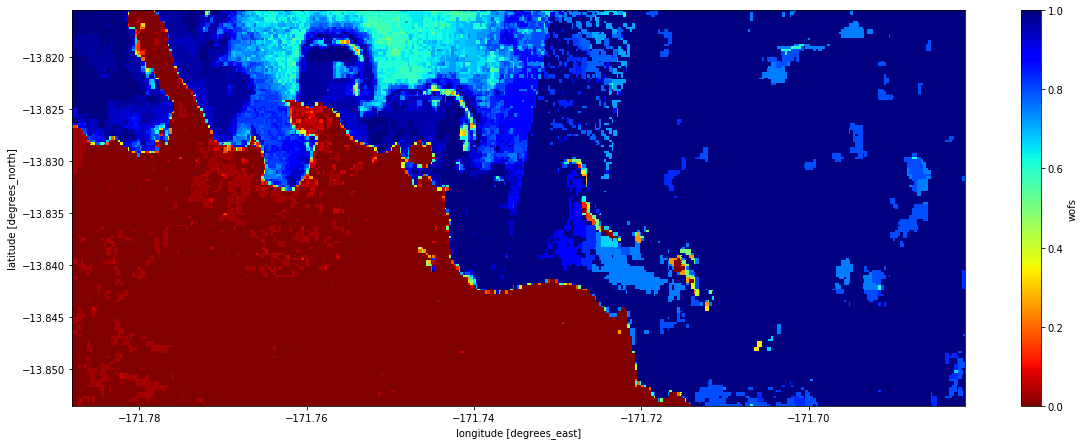

In [27]:
import matplotlib.pyplot as plt  

plt.figure(figsize = aspect_ratio_helper(*reversed(list(water_classifications.wofs.shape)[1:])))
water_classifications.mean(dim = 'time').wofs.plot(cmap = "jet_r")

# Train WASARD water classifier using optical data

>### Import wasard

In [28]:
from utils.data_cube_utilities import wasard

>### Train WASARD classifier
> In this case only data from samoa will be used. In the general case, It is suggested that a geographicall varied dataset is used to train the model.

In [29]:
samoa_classifier = wasard.wasard_classifier(sar_dataset=sentinel_dataset,
                                              landsat_dataset=landsat_dataset)

# Water Classifcation: WASARD

> ### Classify

In [30]:
samoa_classified = samoa_classifier.wasard_classify(sentinel_dataset)

>### Visualize WASARD SAR water classifciaton
>A percentage (between the range of [0-1]) denotes the frequency of water in any given area, 

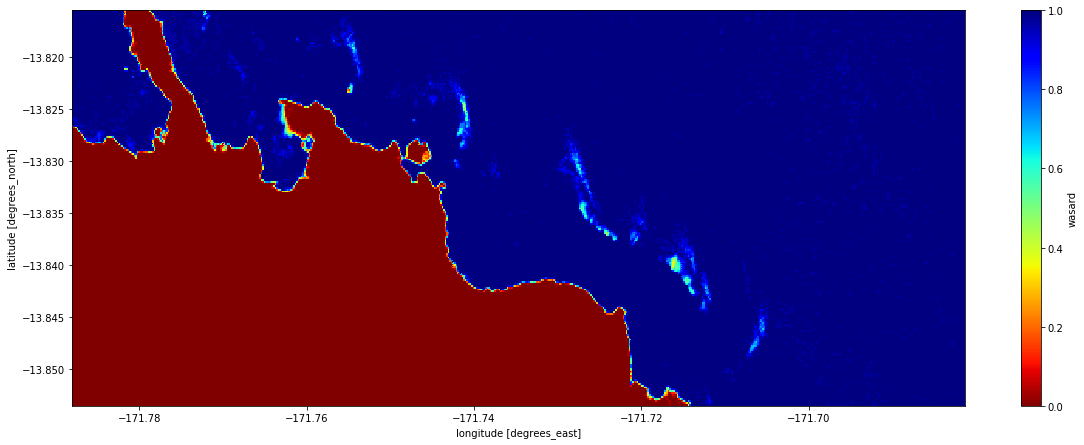

In [31]:
plt.figure(figsize = aspect_ratio_helper(*reversed(list(water_classifications.wofs.shape)[1:])))
samoa_classified.wasard.mean(dim = "time").plot(cmap = "jet_r")